#### load libraries

In [4]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, ElasticNet
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict,cross_validate, GridSearchCV, train_test_split
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 
import statistics
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = None
pd.options.display.max_rows = None
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### load and inspect data

In [6]:
house_df = pd.read_csv('../data/final_df.csv', index_col = 0)

# Checking final_df after generating geoCode, found duplicated observations
house_df.shape

(2603, 179)

In [7]:
# drop duplicated observations
house_df = house_df.drop_duplicates(subset=['PID'],keep = 'first')
house_df.shape

(2558, 179)

#### preprocessing

In [8]:
house_df_use = house_df.copy()

# convert MSSubClass to str
house_df_use['MSSubClass'] = house_df_use[['MSSubClass']].astype('str')

# characterize tax distr and sch distr
house_df_use['TxD_S'] = house_df_use[['TxD_S']].astype('str')
house_df_use['SchD_S'] = house_df_use[['SchD_S']].astype('str')

# convert NA's to 0s in LotFrontage and Alley
house_df_use['LotFrontage'] = np.where(pd.isnull(house_df_use['LotFrontage']), 0, house_df_use['LotFrontage'])
house_df_use['Alley'] = np.where(pd.isnull(house_df_use['Alley']), 0, 1)

# Impute None to Nan value in columns
none_features = ['FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','Fence','BsmtQual','BsmtCond']
for feature in none_features:
    house_df_use[feature] = house_df_use[feature].fillna('None')

# drop rows with NA garage car / garage area
garage_NA_index = house_df_use.loc[pd.isnull(house_df_use['GarageArea'])].index
house_df_use = house_df_use.drop(garage_NA_index,axis=0)

# add in proper bathroom numbers for 918 and 2328
house_df_use.at[918, 'num_bathroom'] = 1
house_df_use.at[2328, 'num_bathroom'] = 3.5

# remove unnecessary columns
house_df_use = house_df_use.drop(
    ['PA-PreD','PA-PostD','PA-UnTyp','PA-UntNo','X1TPr_D','X1TSc_D','Rcrd_Mo','Legal_Pr','TxD_S',\
    'X2TPr_D','X2TSc_D','X1TPr_S','X1TSc_S','X2TPr_S','X2TSc_S','ISU_lat_long','address','MA_Ownr1','MA_Ownr2',\
    'MA_Line1','MA_Line2','MA_City','MA_State','address3','location2','point2','SaleCond','Source','Date',\
    'ParType','BldgNo_S','DwlgNo_S','YrBuilt','Ext1','Ext2','GLA','GarYrBlt','Cars','MA_Zip1','MA_Zip2',\
    'ZngCdPr','ZngCdSc','ZngOLPr','ZngOLSc','PA-Nmbr','PA-Strt','PA-StSfx','Inst1_No','Inst1_Yr','Inst1_Mo',\
    'Inst1TPr','TtlVal_AsrYr','ValType','OthAc_S','ImpAc_S','LndAc_S','Prop_Addr','HSTtl_D','MilVal_D',\
    'HSTtl_S','MilVal_S','GeoRefNo','Tier','Range','AcreX_S1','ClassPr_S','ClassSc_S','LndAcX1S','ImpAcX1S',\
    'Central Air','ImpAcX2S','AcreGr','AcreNt_S','ParclRel','Rcrd_Yr','address2','SaleType',\
    'latitude2','longitude2','ISU_lat','ISU_long','altitude2','Central Air',\

    'index','MiscVal','YrSold_YYYY','MoSold_MM','PoolArea','PoolQC','MiscFeature','Street','PID','Utilities',\
    'BsmtHalfBath2','FullBath','HalfBath','TtlBsmtSF','HalfBath2','BsmtFullBath','BsmtHalfBath',\
    'BsmtFinSF1','BsmtFinSF2','BsmtFinType1','BsmtFinType2','BsmtUnfSF','LowQualFinSF','BasmtFinSF2','BasmtFinSF1',\
    'GrLivArea','1stFlrSF','2ndFlrSF','MasVnrType','MasVnrArea','GarageArea2','PoolArea2','NmbrBRs',\
    'Neighborhood','BedroomAbvGr','TotalBsmtSF','GarageYrBlt','BasmtFinSF','Heating'],\
    axis=1)

print(house_df_use.columns)
print(f'has null: {house_df_use.columns[house_df_use.isnull().sum() > 0]}')

Index(['SalePrice', 'Distance', 'MSSubClass', 'MSZoning', 'LotFrontage',
       'LotArea', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'HeatingQC', 'CentralAir',
       'Electrical', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'Fence', 'MoSold', 'YrSold', 'SaleCondition',
       'MasVnrArea2', 'total_LivArea', 'num_bathroom', 'SchD_S'],
      dtype='object')
has null: Index(['BsmtExposure', 'Electrical'], dtype='object')


#### minimum sample/class size

In [9]:
(1.96 * statistics.stdev(house_df_use['SalePrice']) / 20000)**2

53.87076177104101

#### feature engineering

In [10]:
def feature_eng(df):
    # calculate age of building
    df['BldgAge'] = df['YrSold'] - df['YearBuilt']

    # binarize YearRemodAdd
    df['Remodeled'] = np.where(df['YearRemodAdd'] == df['YearBuilt'], 0, 1)

    # binarize MSSubClass to PUD or not PUD
    df['IsPUD'] = np.where(df['MSSubClass'].isin(['120','150','160','180']), 1, 0)
    
    # binarize LotShape to Reg/not Reg
    df['LotIsReg'] = np.where(df['LotShape']=='Reg', 1, 0)
    
    # binarize LandContour to HLS and Low vs not HLS or Low
    df['HillORDepr'] = np.where(df['LandContour'].isin(['HLS','Low']), 1, 0)
    
    # binarize Condition1/2 to positive feature or no positive feature
    df['PosFeat'] = np.where(df['Condition1'].isin(['PosN','PosA'])|df['Condition2'].isin(['PosN','PosA']), 1, 0)

    # combine exterior material 1/2 to one column
    df['ExtMatl'] = np.where((df['Exterior1st']==df['Exterior2nd']),df['Exterior1st'], 'Mixed')
    
    # covnert Electrical to circuit breakers/
    #df['SBrkrElecOnly']=np.where(df['Electrical']=='SBrkr',1,0)
    
    # simply qual/cond features
    for col in ['ExterQual','BsmtQual','KitchenQual','FireplaceQu','GarageQual','ExterCond',\
                'BsmtCond','GarageCond','HeatingQC']:
        df[col+'_num'] = df[col].replace(['Ex','Gd','TA','Fa','Po','None'],[10,8,6,4,2,0])

    # sum up porch area
    df['Total_porch_sf'] = df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] +\
                                df['ScreenPorch'] + df['WoodDeckSF']
    
    # binarize fences
    df['HasFence'] = np.where(df['Fence']=='None', 0, 1)

    # simplify Functional to 3 classes
    df['Funct_3'] = df['Functional'].replace(['Maj1', 'Maj2', 'Min1', 'Min2', 'Mod', 'Sal', 'Typ'],\
                                             ['ModToSev','ModToSev','Minor','Minor','ModToSev','ModToSev','Normal'])
    
    # binarize sale condition to normal sale condition or not sale condition
    #df['NormalSaleCond'] = np.where(df['SaleCondition']=='Normal', 1, 0)
    
    # drop the original columns or unused columns
    df = df.drop(['MSSubClass','YearBuilt','YearRemodAdd','LotFrontage','LotArea','LotConfig','LandSlope',\
                  'Condition1','Condition2','Exterior1st','Exterior2nd','LotShape','LandContour',\
                  'OpenPorchSF','3SsnPorch','EnclosedPorch','ScreenPorch','WoodDeckSF',\
                  'Fence','Functional','ExterQual','BsmtQual','KitchenQual','FireplaceQu',\
                  'GarageQual','ExterCond','BsmtCond','GarageCond','HeatingQC',\
                  'GarageCars','RoofMatl','RoofStyle','KitchenAbvGr','MSZoning'],\
                 axis = 1)
    return df

In [11]:
house_df_eng = feature_eng(house_df_use)

In [12]:
house_df_eng.columns

Index(['SalePrice', 'Distance', 'Alley', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'Foundation', 'BsmtExposure',
       'CentralAir', 'Electrical', 'TotRmsAbvGrd', 'Fireplaces', 'GarageType',
       'GarageFinish', 'GarageArea', 'PavedDrive', 'MoSold', 'YrSold',
       'SaleCondition', 'MasVnrArea2', 'total_LivArea', 'num_bathroom',
       'SchD_S', 'BldgAge', 'Remodeled', 'IsPUD', 'LotIsReg', 'HillORDepr',
       'PosFeat', 'ExtMatl', 'ExterQual_num', 'BsmtQual_num',
       'KitchenQual_num', 'FireplaceQu_num', 'GarageQual_num', 'ExterCond_num',
       'BsmtCond_num', 'GarageCond_num', 'HeatingQC_num', 'Total_porch_sf',
       'HasFence', 'Funct_3'],
      dtype='object')

#### dummification and log transformation

In [13]:
# dummify the dataset
house_df_dum = pd.get_dummies(house_df_eng, drop_first=True)
print(house_df_dum.shape)
print(house_df_dum.shape)

# apply log()
house_df_dum['SalePrice'] = np.log(house_df_dum['SalePrice'])
house_df_dum['total_LivArea'] = np.log(house_df_dum['total_LivArea'])
#house_df_dum['Distance'] = np.log(X_train_dum['Distance'])
house_df_dum['Total_porch_sf'] = np.log(house_df_dum['Total_porch_sf']+1)

(2557, 84)
(2557, 84)


#### test-train split

In [14]:
len(house_df_dum[house_df_dum['YrSold']==2010])

314

In [15]:
train = house_df_dum[house_df_dum['YrSold']!=2010]
test = house_df_dum[house_df_dum['YrSold']==2010]
print(train.shape)
print(test.shape)

X_train = train.drop(['SalePrice','YrSold'],axis=1)
y_train = train['SalePrice']
X_test = test.drop(['SalePrice','YrSold'],axis=1)
y_test = test['SalePrice']

(2243, 84)
(314, 84)


#### linear regression, p-values, and VIFs

In [16]:
lin_reg = LinearRegression().fit(X_train, y_train)
lin_reg.score(X_train, y_train)

x_feature = sm.add_constant(X_train)

model = sm.OLS(y_train, x_feature)
results_feature = model.fit()
print(results_feature.summary())
pValue = results_feature.pvalues
pValue[pValue<0.05]

#X_vif = X_train_dum[pValue[pValue<0.05].index]
X_vif = X_train[pValue[pValue<0.05].drop('const').index]
vif_data = pd.DataFrame() 
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) 
                          for i in range(len(X_vif.columns))] 
print(vif_data)

0.9135884502297468

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     278.5
Date:                Sun, 29 Nov 2020   Prob (F-statistic):               0.00
Time:                        13:50:12   Log-Likelihood:                 1720.8
No. Observations:                2243   AIC:                            -3276.
Df Residuals:                    2160   BIC:                            -2801.
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     8.48

const                    0.000000e+00
Distance                 7.342637e-12
OverallQual              2.061792e-73
OverallCond              2.053056e-39
TotRmsAbvGrd             1.885858e-31
Fireplaces               3.340927e-09
GarageArea               1.444154e-31
total_LivArea            1.543069e-96
num_bathroom             2.232136e-06
BldgAge                  2.088693e-12
LotIsReg                 4.522439e-03
HillORDepr               1.224148e-05
ExterQual_num            5.100802e-03
BsmtQual_num             2.948366e-06
KitchenQual_num          1.095704e-05
HeatingQC_num            1.912565e-04
Total_porch_sf           1.444937e-02
BldgType_2fmCon          1.264813e-03
BldgType_Duplex          1.148426e-09
BldgType_Twnhs           7.034307e-03
HouseStyle_1Story        5.700589e-03
HouseStyle_2Story        5.085207e-03
HouseStyle_SLvl          4.581167e-03
Foundation_CBlock        4.059015e-02
Foundation_PConc         3.918517e-03
BsmtExposure_Gd          2.862583e-03
BsmtExposure

                  feature         VIF
0                Distance   15.634547
1             OverallQual   71.727564
2             OverallCond   40.114700
3            TotRmsAbvGrd   39.632187
4              Fireplaces    2.776179
5              GarageArea   10.525371
6           total_LivArea  327.026423
7            num_bathroom   20.995611
8                 BldgAge   13.020247
9                LotIsReg    3.265150
10             HillORDepr    1.197003
11          ExterQual_num  107.570941
12           BsmtQual_num   40.307674
13        KitchenQual_num   72.726906
14          HeatingQC_num   33.735544
15         Total_porch_sf    7.170602
16        BldgType_2fmCon    1.185849
17        BldgType_Duplex    1.357928
18         BldgType_Twnhs    1.216124
19      HouseStyle_1Story    5.369455
20      HouseStyle_2Story    3.958848
21        HouseStyle_SLvl    1.473855
22      Foundation_CBlock    6.580818
23       Foundation_PConc    9.633890
24        BsmtExposure_Gd    1.874520
25        Bs

#### train and test error

In [17]:
lin_reg.score(X_train, y_train)
lin_reg.score(X_test, y_test)

0.9135884502297468

0.8495734360021534

#### lasso

In [18]:
X_train_lasso = X_train.copy()
y_train_lasso = y_train.copy()
X_test_lasso = X_test.copy()
y_test_lasso = y_test.copy()

In [26]:
np.linspace(0.00001,1.1,0.00001)

TypeError: 'float' object cannot be interpreted as an integer

Lasso()

Lasso(alpha=0.1)

Lasso(alpha=0.1)

Lasso(alpha=1.1526315789473685)

Lasso(alpha=1.1526315789473685)

Lasso(alpha=2.205263157894737)

Lasso(alpha=2.205263157894737)

Lasso(alpha=3.2578947368421054)

Lasso(alpha=3.2578947368421054)

Lasso(alpha=4.310526315789473)

Lasso(alpha=4.310526315789473)

Lasso(alpha=5.363157894736841)

Lasso(alpha=5.363157894736841)

Lasso(alpha=6.41578947368421)

Lasso(alpha=6.41578947368421)

Lasso(alpha=7.468421052631578)

Lasso(alpha=7.468421052631578)

Lasso(alpha=8.521052631578947)

Lasso(alpha=8.521052631578947)

Lasso(alpha=9.573684210526315)

Lasso(alpha=9.573684210526315)

Lasso(alpha=10.626315789473683)

Lasso(alpha=10.626315789473683)

Lasso(alpha=11.678947368421051)

Lasso(alpha=11.678947368421051)

Lasso(alpha=12.73157894736842)

Lasso(alpha=12.73157894736842)

Lasso(alpha=13.784210526315789)

Lasso(alpha=13.784210526315789)

Lasso(alpha=14.836842105263157)

Lasso(alpha=14.836842105263157)

Lasso(alpha=15.889473684210525)

Lasso(alpha=15.889473684210525)

Lasso(alpha=16.942105263157895)

Lasso(alpha=16.942105263157895)

Lasso(alpha=17.994736842105265)

Lasso(alpha=17.994736842105265)

Lasso(alpha=19.04736842105263)

Lasso(alpha=19.04736842105263)

Lasso(alpha=20.1)

Lasso(alpha=20.1)

<Figure size 1080x1080 with 0 Axes>

Text(0.5, 0, 'hyperparameter $\\lambda$')

Text(0, 0.5, 'slope values')

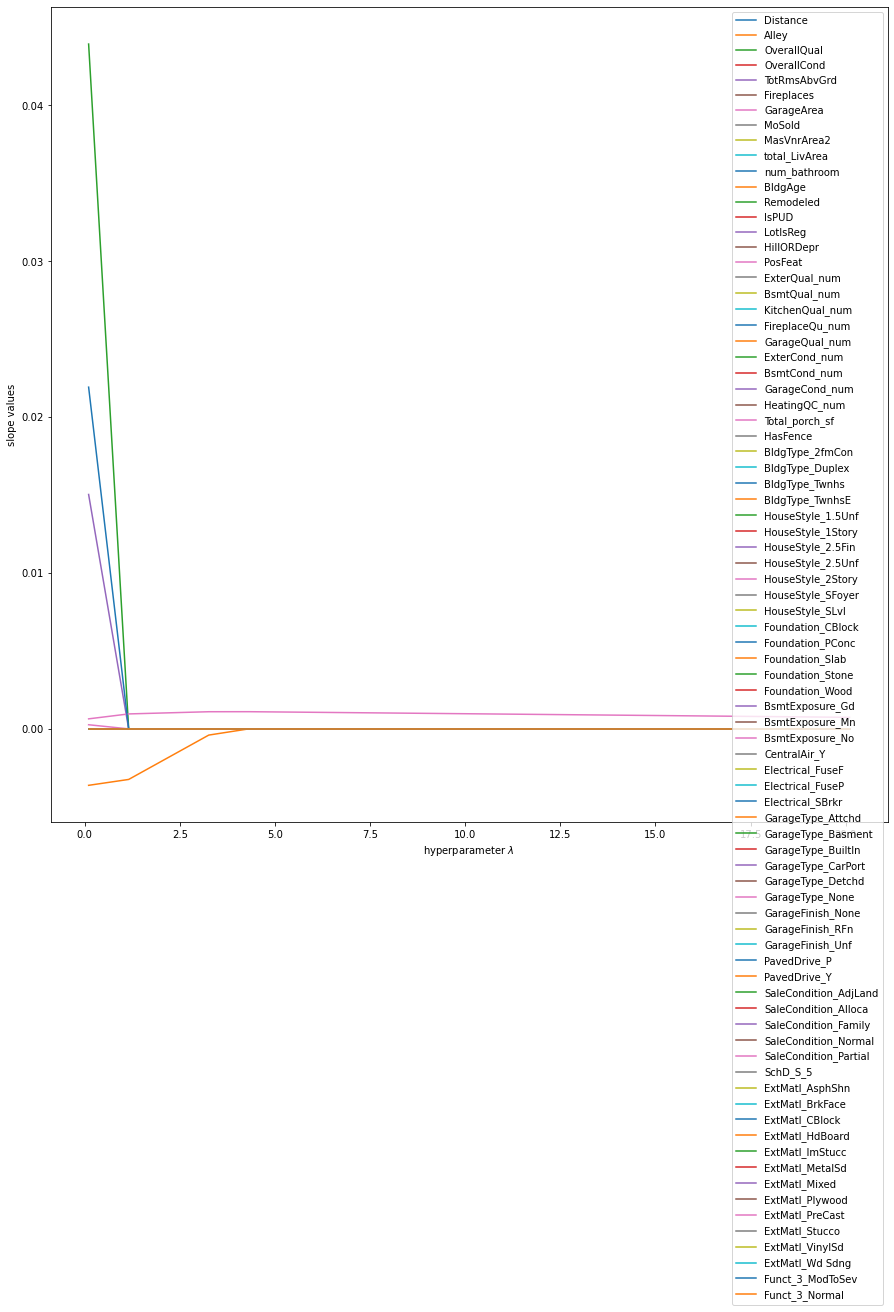

In [27]:
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
lasso  = Lasso()
alphas = np.linspace(0.1,20.1,20)
lasso.set_params(normalize=False)
coefs_lasso  = []

for alpha in alphas:
        lasso.set_params(alpha=alpha)
        lasso.fit(X_train_lasso, y_train_lasso)  
        coefs_lasso.append(lasso.coef_)

coefs_lasso = pd.DataFrame(coefs_lasso, index = alphas, columns = X_train_lasso.columns)  
# coefs_lasso.head()
plt.figure(figsize=(15,15))
for name in coefs_lasso.columns:
    plt.plot(coefs_lasso.index, coefs_lasso[name], label=name)
plt.xlabel(r'hyperparameter $\lambda$')
plt.ylabel(r'slope values')
plt.legend(loc=1)   

In [28]:
# best best fit alpha
reg_lasso_cv = LassoCV(normalize = True, n_alphas = 200)
reg_lasso_cv.fit(X_train_lasso, y_train_lasso)
reg_lasso_cv.alpha_

LassoCV(n_alphas=200, normalize=True)

3.0508293036878217e-05

In [29]:
# put the alpha value back in the original lasso
reg_lasso = Lasso(normalize=True)
reg_lasso.set_params(alpha = 2.846e-05)
reg_lasso.fit(X_train_lasso, y_train_lasso)
lasso_coef_df = pd.DataFrame({'feature':X_train_lasso.columns,
                              'coef':reg_lasso.coef_})
lasso_coef_df[lasso_coef_df['coef']>0]

Lasso(alpha=2.846e-05, normalize=True)

Lasso(alpha=2.846e-05, normalize=True)

,feature,coef
2,OverallQual,0.068231
3,OverallCond,0.036547
4,TotRmsAbvGrd,0.028729
5,Fireplaces,0.045729
6,GarageArea,0.000220
8,MasVnrArea2,0.002674
9,total_LivArea,0.287412
10,num_bathroom,0.022064
15,HillORDepr,0.048149
16,PosFeat,0.017976


#### test and train errors (lasso)

In [30]:
print(reg_lasso.score(X_train_lasso, y_train_lasso))
reg_lasso.score(X_test_lasso, y_test_lasso)

0.9122061513905892


0.8445759479422783

R^2 of Train set: 0.9392162649711132
R^2 Test set: 0.7711488700204874
          feature  importance
0   b'OverallQua'    0.572968
1   b'total_LivA'    0.276478
2   b'num_bathro'    0.034258
3   b'GarageArea'    0.027585
4      b'BldgAge'    0.013129
5     b'Distance'    0.010373
6   b'Fireplaces'    0.009876
7   b'BsmtQual_n'    0.006316
8   b'Total_porc'    0.005857
9        b'IsPUD'    0.003759
10  b'OverallCon'    0.003594
11  b'SaleCondit'    0.002723
12  b'TotRmsAbvG'    0.002615
13  b'BsmtCond_n'    0.002514
14  b'HeatingQC_'    0.002417
15  b'SaleCondit'    0.002339
16  b'Funct_3_No'    0.001803
17  b'CentralAir'    0.001792
18  b'FireplaceQ'    0.001626
19  b'HouseStyle'    0.001620


<AxesSubplot:xlabel='name'>

Text(0.5, 1.0, 'Feature Importance Plot of Decision Tree')

DecisionTreeRegressor(max_depth=8, random_state=42)

Wall time: 16.9 s


GridSearchCV(cv=10,
             estimator=DecisionTreeRegressor(max_depth=8, random_state=42),
             n_jobs=-1,
             param_grid=[{'criterion': ['mse'],
                          'min_samples_leaf': range(1, 10),
                          'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30])}],
             scoring='r2')

Grid Search Best Parameters: {'criterion': 'mse', 'min_samples_leaf': 6, 'min_samples_split': 30}
Grid Search Best Scores: 0.8242270257400278
Grid Search R2 of Train set: 0.9008652674127656
Grid Search R2 of Test set: 0.7978645832723026


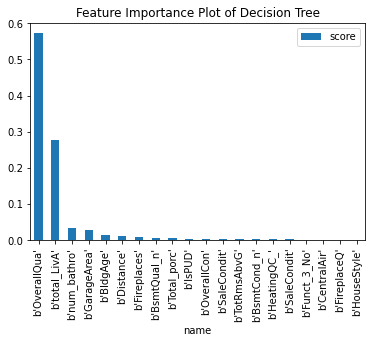

In [197]:
# Decision Tree Model
tree_reg = DecisionTreeRegressor(max_depth=8).fit(X_train,y_train)
print(f'R^2 of Train set: {tree_reg.score(X_train,y_train)}')
print(f'R^2 Test set: {tree_reg.score(X_test,y_test)}')

feature_importance_tree = list(zip(X_train.columns ,tree_reg.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance_tree = np.array(feature_importance_tree, dtype=dtype)
feature_sort_tree = np.sort(feature_importance_tree, order = 'importance')[::-1]
name, score = zip(*list(feature_sort_tree))
print(pd.DataFrame(feature_sort_tree[:20]))
pd.DataFrame({'name':name,'score':score})[:20].plot.bar(x='name', y='score')
plt.title('Feature Importance Plot of Decision Tree')


from sklearn.model_selection import GridSearchCV
grid_para_tree = [{
    "criterion": ['mse'],
    "min_samples_leaf": range(1, 10),
    "min_samples_split": np.linspace(start=2, stop=30, num=15, dtype=int)
}]
tree_reg.set_params(random_state=42)
grid_search_tree = GridSearchCV(tree_reg, grid_para_tree, cv=10, scoring='r2', n_jobs=-1)
%time grid_search_tree.fit(X_train, y_train)

print(f'Grid Search Best Parameters: {grid_search_tree.best_params_}')

print(f'Grid Search Best Scores: {grid_search_tree.best_score_}')

print(f'Grid Search R2 of Train set: {grid_search_tree.score(X_train,y_train)}')
print(f'Grid Search R2 of Test set: {grid_search_tree.score(X_test,y_test)}')



DecisionTreeRegressor(max_depth=5, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=6, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=6, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=7, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=7, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=8, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=8, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=9, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=9, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=11, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=11, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=12, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=12, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=13, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=13, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=14, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=14, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=15, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=15, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=16, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=16, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=17, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=17, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=18, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=18, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=19, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=19, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=20, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=20, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=21, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=21, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=22, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=22, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=23, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=23, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=24, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=24, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=25, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=25, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=26, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=26, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=27, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=27, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=28, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=28, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=29, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=29, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=30, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=30, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=31, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=31, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=32, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=32, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=33, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=33, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=34, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=34, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=35, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=35, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=36, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=36, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=37, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=37, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=38, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=38, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=39, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=39, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=40, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=40, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=41, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=41, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=42, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=42, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=43, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=43, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=44, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=44, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=45, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=45, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=46, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=46, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=47, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=47, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=48, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=48, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=49, min_samples_leaf=9, random_state=42)

DecisionTreeRegressor(max_depth=49, min_samples_leaf=9, random_state=42)

(0.0, 0.3)

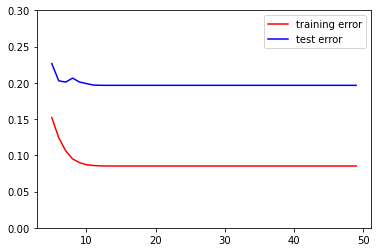

In [191]:
depth = range(5, 50)
train_error = []
test_error = []
for i in depth:
    tree_reg.set_params(max_depth=i, min_samples_leaf=9)
    tree_reg.fit(X_train, y_train)
    train_error.append(1 - tree_reg.score(X_train, y_train))
    test_error.append(1 - tree_reg.score(X_test, y_test))

plt.plot(depth, train_error, c='red', label='training error')
plt.plot(depth, test_error, c='blue', label='test error')
plt.ylim(0, 0.30)
plt.legend()
plt.show()

R^2 of Train set: 0.9841730832313217
R^2 Test set: 0.8164917662364661
          feature  importance
0   b'total_LivA'    0.110034
1   b'OverallQua'    0.100783
2   b'GarageArea'    0.060992
3      b'BldgAge'    0.058554
4   b'num_bathro'    0.057906
5   b'ExterQual_'    0.047532
6   b'BsmtQual_n'    0.045820
7   b'KitchenQua'    0.045088
8   b'FireplaceQ'    0.041162
9   b'Fireplaces'    0.039848
10  b'TotRmsAbvG'    0.036117
11  b'Total_porc'    0.028574
12  b'Foundation'    0.023933
13  b'HeatingQC_'    0.020252
14    b'Distance'    0.018985
15  b'GarageType'    0.017300
16  b'OverallCon'    0.016439
17  b'MasVnrArea'    0.013573
18  b'GarageFini'    0.013447
19  b'GarageType'    0.013419


<AxesSubplot:xlabel='name'>

Text(0.5, 1.0, 'Feature Importance Plot of 500 Trees Random Forest')

Wall time: 25min 5s


GridSearchCV(cv=10,
             estimator=RandomForestRegressor(max_features=5, n_estimators=500),
             n_jobs=-1,
             param_grid=[{'criterion': ['mse'],
                          'min_samples_leaf': range(1, 10),
                          'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]),
                          'n_estimators': [100, 500, 1000],
                          'random_state': [42]}],
             scoring='r2')

Grid Search Best Parameters: {'criterion': 'mse', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000, 'random_state': 42}
Grid Search Best Scores: 0.8823353968506378
Grid Search R2 of Train set: 0.9843006433016751
Grid Search R2 of Test set: 0.8190395801037075


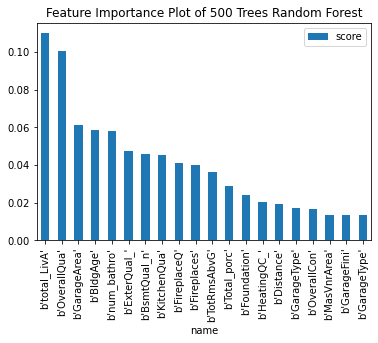

In [183]:
# Random Forest Model
forest_reg = RandomForestRegressor(n_estimators=100,max_features=5).fit(X_train,y_train)
print(f'R^2 of Train set: {forest_reg.score(X_train,y_train)}')
print(f'R^2 Test set: {forest_reg.score(X_test,y_test)}')


feature_importance_forest = list(zip(X_train.columns, forest_reg.feature_importances_))
feature_importance_forest = np.array(feature_importance_forest, dtype=dtype)
feature_sort_forest = np.sort(feature_importance_forest, order='importance')[::-1]
name, score = zip(*list(feature_sort_forest))
print(pd.DataFrame(feature_sort_forest[:20]))
pd.DataFrame({'name':name,'score':score})[:20].plot.bar(x='name', y='score')
plt.title('Feature Importance Plot of 500 Trees Random Forest')


grid_para_forest = [{
    "n_estimators": [25,50,100],
    "criterion": ["mse"],
    "min_samples_leaf": range(1, 10),
    "min_samples_split": np.linspace(start=2, stop=30, num=15, dtype=int),
    "random_state": [42]}]
grid_search_forest = GridSearchCV(forest_reg, grid_para_forest, cv=10, scoring='r2', n_jobs=-1)
%time grid_search_forest.fit(X_train, y_train)

print(f'Grid Search Best Parameters: {grid_search_forest.best_params_}')

print(f'Grid Search Best Scores: {grid_search_forest.best_score_}')

print(f'Grid Search R2 of Train set: {grid_search_forest.score(X_train,y_train)}')
print(f'Grid Search R2 of Test set: {grid_search_forest.score(X_test,y_test)}')

RandomForestRegressor(max_features=9)

RandomForestRegressor(max_features=9)

RandomForestRegressor(max_features=9, n_estimators=200)

RandomForestRegressor(max_features=9, n_estimators=200)

RandomForestRegressor(max_features=9, n_estimators=300)

RandomForestRegressor(max_features=9, n_estimators=300)

RandomForestRegressor(max_features=9, n_estimators=400)

RandomForestRegressor(max_features=9, n_estimators=400)

RandomForestRegressor(max_features=9, n_estimators=500)

RandomForestRegressor(max_features=9, n_estimators=500)

RandomForestRegressor(max_features=9, n_estimators=600)

RandomForestRegressor(max_features=9, n_estimators=600)

RandomForestRegressor(max_features=9, n_estimators=700)

RandomForestRegressor(max_features=9, n_estimators=700)

RandomForestRegressor(max_features=9, n_estimators=800)

RandomForestRegressor(max_features=9, n_estimators=800)

RandomForestRegressor(max_features=9, n_estimators=900)

RandomForestRegressor(max_features=9, n_estimators=900)

Text(0, 0.5, 'Error')

Text(0.5, 0, 'Number of trees')

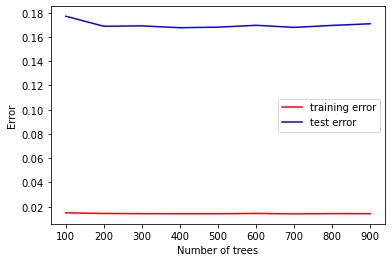

In [196]:
n_trees_range = range(100, 1000, 100)  # OOB score will warning if too few trees
train_error2 = []
test_error2 = []


for n_trees in n_trees_range:
    forest_reg.set_params(n_estimators=n_trees)
    forest_reg.fit(X_train, y_train)
    train_error2.append(1 - forest_reg.score(X_train, y_train))
    test_error2.append(1 - forest_reg.score(X_test, y_test))
    

plt.plot(n_trees_range, train_error2, c='red', label='training error')
plt.plot(n_trees_range, test_error2, c='blue', label='test error')
plt.ylabel('Error')
plt.xlabel('Number of trees')
plt.legend()
plt.show()

GradientBoostingRegressor(learning_rate=0.01, max_features=2,
                          min_impurity_decrease=0.01, n_estimators=5000,
                          verbose=1)

R^2 of Train set: 0.9437494451303968
R^2 Test set: 0.8579435799921262
                    0         1
0         OverallQual  0.378596
1       total_LivArea  0.342979
2          GarageArea  0.060320
3             BldgAge  0.035058
4     FireplaceQu_num  0.033718
5     KitchenQual_num  0.020519
6         OverallCond  0.020216
7       ExterQual_num  0.018593
8        num_bathroom  0.012516
9        CentralAir_Y  0.011818
10       TotRmsAbvGrd  0.007099
11     Total_porch_sf  0.006833
12     GarageCond_num  0.006783
13  GarageType_Attchd  0.006551
14           Distance  0.004888
15         Fireplaces  0.004547
16       BsmtQual_num  0.004354
17      HeatingQC_num  0.004228
18              IsPUD  0.004211
19     BldgType_Twnhs  0.002803


<AxesSubplot:xlabel='feature_name'>

Text(0.5, 1.0, 'Feature Importance Plot of 1000-Tree GBM')

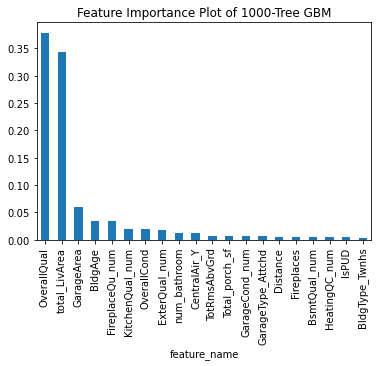

In [212]:
# Gradient Boosting Model
from sklearn.ensemble import GradientBoostingRegressor

gbm.set_params(learning_rate=0.01, n_estimators=5000, verbose=1, warm_start=False,loss='ls',max_features=2, min_impurity_decrease=0.01)
gbm = GradientBoostingRegressor().fit(X_train,y_train)

print(f'R^2 of Train set: {gbm.score(X_train,y_train)}')
print(f'R^2 Test set: {gbm.score(X_test,y_test)}')


sorted_importance_gbm = sorted(zip(X_train.columns, gbm.feature_importances_), key=lambda t:t[1], reverse=True)
print(pd.DataFrame(sorted_importance_gbm[:20]))
a, b = zip(*sorted_importance_gbm[:20]) # this splits the list of tuples into two lists
pd.DataFrame({'feature_name':a, 'importance_score':b}).plot.bar(x='feature_name',y='importance_score', legend=None)
plt.title('Feature Importance Plot of 1000-Tree GBM')


In [218]:
from sklearn.metrics import r2_score
# The staged_predict returns generators

gen_train = gbm.staged_predict(X_train)
gen_test  = gbm.staged_predict(X_test)

trainR2 = []
testR2  = []
steps   = range(1,5000)
for n in steps:
    y_pred_train = next(gen_train)
    y_pred_test  = next(gen_test)
    trainR2.append(1-r2_score(y_pred_train, y_train))
    testR2.append(1-r2_score(y_pred_test, y_test))

start = 4000
plt.plot(steps[start:], trainR2[start:],label='train')
plt.plot(steps[start:], testR2[start:],label='test')
plt.legend(loc=4)
plt.xlabel('n_estimators')
plt.ylabel(r'Error')

StopIteration: 

R^2 of Train set: 0.9730500063092957
R^2 Test set: 0.7745819630839452
          feature  importance
0   b'OverallQua'    0.553726
1   b'total_LivA'    0.271573
2   b'num_bathro'    0.031992
3   b'GarageArea'    0.030643
4      b'BldgAge'    0.014190
5     b'Distance'    0.012793
6   b'Fireplaces'    0.011165
7   b'Total_porc'    0.009057
8   b'BsmtQual_n'    0.007471
9   b'OverallCon'    0.005607
10  b'HeatingQC_'    0.004317
11  b'TotRmsAbvG'    0.003669
12       b'IsPUD'    0.003296
13  b'SaleCondit'    0.002681
14  b'CentralAir'    0.002472
15  b'SaleCondit'    0.002327
16      b'MoSold'    0.002290
17  b'FireplaceQ'    0.002277
18  b'Funct_3_No'    0.001965
19  b'PavedDrive'    0.001888


<AxesSubplot:xlabel='name'>

Text(0.5, 1.0, 'Feature Importance Plot of Decision Tree')

DecisionTreeRegressor(max_depth=10, random_state=42)

Wall time: 9.09 s


GridSearchCV(cv=10,
             estimator=DecisionTreeRegressor(max_depth=10, random_state=42),
             n_jobs=-1,
             param_grid=[{'criterion': ['mse'],
                          'min_samples_leaf': range(1, 10),
                          'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30])}],
             scoring='r2')

Grid Search Best Parameters: {'criterion': 'mse', 'min_samples_leaf': 9, 'min_samples_split': 26}
Grid Search Best Scores: 0.8243333314095418
Grid Search R2 of Train set: 0.9052479388758785
Grid Search R2 of Test set: 0.7988752035054203


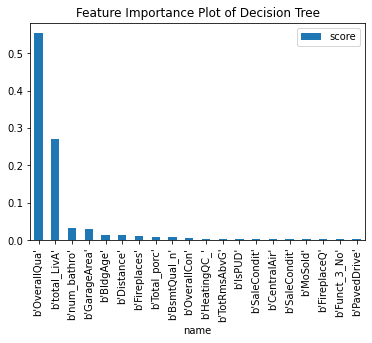

In [170]:
# Decision Tree Model
tree_reg = DecisionTreeRegressor(max_depth=10).fit(X_train,y_train)
print(f'R^2 of Train set: {tree_reg.score(X_train,y_train)}')
print(f'R^2 Test set: {tree_reg.score(X_test,y_test)}')

feature_importance_tree = list(zip(X_train.columns ,tree_reg.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance_tree = np.array(feature_importance_tree, dtype=dtype)
feature_sort_tree = np.sort(feature_importance_tree, order = 'importance')[::-1]
name, score = zip(*list(feature_sort_tree))
print(pd.DataFrame(feature_sort_tree[:20]))
pd.DataFrame({'name':name,'score':score})[:20].plot.bar(x='name', y='score')
plt.title('Feature Importance Plot of Decision Tree')


from sklearn.model_selection import GridSearchCV
grid_para_tree = [{
    "criterion": ['mse'],
    "min_samples_leaf": range(1, 10),
    "min_samples_split": np.linspace(start=2, stop=30, num=15, dtype=int)
}]
tree_reg.set_params(random_state=42)
grid_search_tree = GridSearchCV(tree_reg, grid_para_tree, cv=10, scoring='r2', n_jobs=-1)
%time grid_search_tree.fit(X_train, y_train)

print(f'Grid Search Best Parameters: {grid_search_tree.best_params_}')

print(f'Grid Search Best Scores: {grid_search_tree.best_score_}')

print(f'Grid Search R2 of Train set: {grid_search_tree.score(X_train,y_train)}')
print(f'Grid Search R2 of Test set: {grid_search_tree.score(X_test,y_test)}')

<AxesSubplot:xlabel='name'>

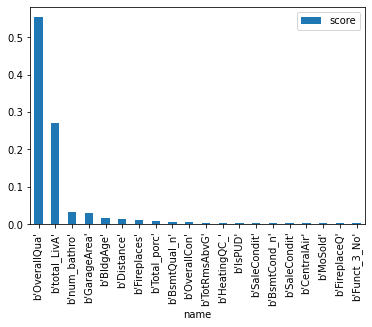

In [73]:
feature_importance = list(zip(X_train.columns ,tree_reg.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance = np.array(feature_importance, dtype=dtype)
feature_sort = np.sort(feature_importance, order='importance')[::-1]
name, score = zip(*list(feature_sort))
pd.DataFrame({'name':name,'score':score})[:20].plot.bar(x='name', y='score')

In [108]:
from sklearn.model_selection import GridSearchCV
grid_para_tree = [{
    "criterion": ['mse'],
    "min_samples_leaf": range(1, 10),
    "min_samples_split": np.linspace(start=2, stop=30, num=15, dtype=int)
}]
tree_reg.set_params(random_state=42)
grid_search_tree = GridSearchCV(tree_reg, grid_para_tree, cv=10, scoring='r2', n_jobs=-1)
%time grid_search_tree.fit(X_train, y_train)

print(grid_search_tree.best_params_)

print(grid_search_tree.best_score_)

DecisionTreeRegressor(max_depth=5, random_state=42)

Wall time: 15.1 s


GridSearchCV(cv=10,
             estimator=DecisionTreeRegressor(max_depth=5, random_state=42),
             n_jobs=-1,
             param_grid=[{'criterion': ['mse'],
                          'min_samples_leaf': range(1, 10),
                          'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30])}],
             scoring='r2')

{'criterion': 'mse', 'min_samples_leaf': 6, 'min_samples_split': 2}
0.804201578110041


<AxesSubplot:xlabel='name'>

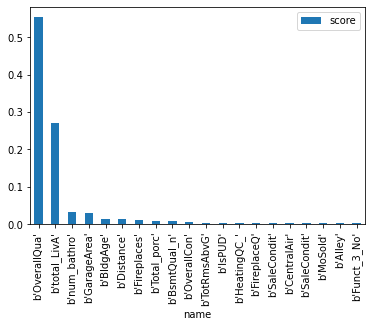

In [37]:
feature_importance = list(zip(X_train_lasso.columns, forest_reg.feature_importances_))
print(pd.DataFrame(sorted(feature_importance,reverse=True)[:20]))
feature_importance = list(zip(X_train_lasso.columns ,tree_reg.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance = np.array(feature_importance, dtype=dtype)
feature_sort = np.sort(feature_importance, order='importance')[::-1]
name, score = zip(*list(feature_sort))
pd.DataFrame({'name':name,'score':score})[:20].plot.bar(x='name', y='score')


R^2 of Train set: 0.9844097627038726
R^2 Test set: 0.8190025660481522
          feature  importance
0   b'total_LivA'    0.108641
1   b'OverallQua'    0.107325
2   b'GarageArea'    0.063674
3      b'BldgAge'    0.056617
4   b'num_bathro'    0.056240
5   b'ExterQual_'    0.051328
6   b'BsmtQual_n'    0.048699
7   b'KitchenQua'    0.044085
8   b'FireplaceQ'    0.038231
9   b'TotRmsAbvG'    0.035679
10  b'Fireplaces'    0.032542
11  b'Total_porc'    0.028312
12  b'HeatingQC_'    0.023739
13    b'Distance'    0.019984
14  b'Foundation'    0.017802
15  b'OverallCon'    0.015736
16  b'GarageType'    0.014772
17  b'GarageFini'    0.013720
18  b'GarageType'    0.013303
19  b'GarageCond'    0.012918


<AxesSubplot:xlabel='name'>

Text(0.5, 1.0, 'Feature Importance Plot of 500 Trees Random Forest')

KeyboardInterrupt: 

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

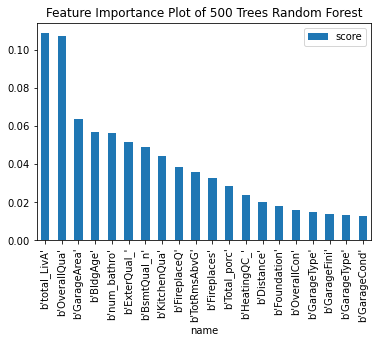

In [177]:
# Random Forest Model
forest_reg = RandomForestRegressor(n_estimators=500,max_features=5).fit(X_train,y_train)
print(f'R^2 of Train set: {forest_reg.score(X_train,y_train)}')
print(f'R^2 Test set: {forest_reg.score(X_test,y_test)}')


feature_importance_forest = list(zip(X_train.columns, forest_reg.feature_importances_))
feature_importance_forest = np.array(feature_importance_forest, dtype=dtype)
feature_sort_forest = np.sort(feature_importance_forest, order='importance')[::-1]
name, score = zip(*list(feature_sort_forest))
print(pd.DataFrame(feature_sort_forest[:20]))
pd.DataFrame({'name':name,'score':score})[:20].plot.bar(x='name', y='score')
plt.title('Feature Importance Plot of 500 Trees Random Forest')

grid_search_forest = GridSearchCV(forest_reg, grid_para_forest, cv=5, scoring='r2', n_jobs=-1)
%time grid_search_forest.fit(X_train, y_train)

print(grid_search_forest.best_params_)

print(grid_search_forest.best_score_)


          feature  importance
0   b'total_LivA'    0.113929
1   b'OverallQua'    0.091483
2   b'GarageArea'    0.067274
3      b'BldgAge'    0.064811
4   b'num_bathro'    0.055812
5   b'KitchenQua'    0.050743
6   b'BsmtQual_n'    0.049874
7   b'ExterQual_'    0.048937
8   b'FireplaceQ'    0.040308
9   b'TotRmsAbvG'    0.037356
10  b'Fireplaces'    0.033592
11  b'Total_porc'    0.030464
12    b'Distance'    0.019653
13  b'HeatingQC_'    0.019385
14  b'Foundation'    0.018574
15  b'GarageType'    0.015937
16  b'OverallCon'    0.015520
17  b'GarageFini'    0.013263
18  b'MasVnrArea'    0.013218
19  b'GarageType'    0.012772


<AxesSubplot:xlabel='name'>

Text(0.5, 1.0, 'Feature Importance Plot of 500 Trees Random Forest')

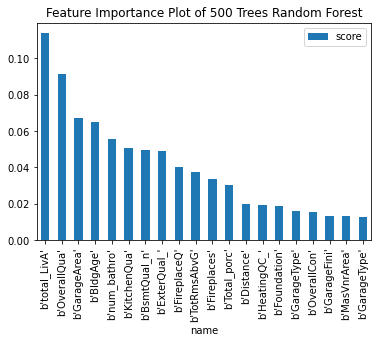

In [164]:
feature_importance_forest = list(zip(X_train.columns, forest_reg.feature_importances_))
feature_importance_forest = np.array(feature_importance_forest, dtype=dtype)
feature_sort_forest = np.sort(feature_importance_forest, order='importance')[::-1]
name, score = zip(*list(feature_sort_forest))
print(pd.DataFrame(feature_sort_forest[:20]))
pd.DataFrame({'name':name,'score':score})[:20].plot.bar(x='name', y='score')
plt.title('Feature Importance Plot of 500 Trees Random Forest')

In [109]:
# grid_para_forest = [{
#     "criterion": ['mse'],
#     "min_samples_leaf": range(1, 10),
#     "min_samples_split": np.linspace(start=2, stop=30, num=15, dtype=int)
# }]

grid_para_forest = [{
    "n_estimators": [25, 50, 100],
    "criterion": ["mse"],
    "min_samples_leaf": range(1, 10),
    "min_samples_split": np.linspace(start=2, stop=30, num=15, dtype=int),
    "random_state": [42]}]

# forest_reg.set_params(random_state=108)
grid_search_forest = GridSearchCV(forest_reg, grid_para_forest, cv=5, scoring='r2', n_jobs=-1)
%time grid_search_forest.fit(X_train, y_train)

print(grid_search_forest.best_params_)

print(grid_search_forest.best_score_)

Wall time: 4min 7s


GridSearchCV(cv=10,
             estimator=RandomForestRegressor(max_features=5, n_estimators=1000,
                                             random_state=108),
             n_jobs=-1,
             param_grid=[{'criterion': ['mse'],
                          'min_samples_leaf': range(1, 10),
                          'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]),
                          'n_estimators': [25, 50, 100],
                          'random_state': [42]}],
             scoring='r2')

{'criterion': 'mse', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100, 'random_state': 42}
0.8795666021656692


In [116]:
# Gradient Boosting Model
from sklearn.ensemble import GradientBoostingRegressor

gbm.set_params(learning_rate=0.1, n_estimators=1000, verbose=1,warm_start=False, loss='ls', max_depth=2,\
               max_features=2, min_impurity_decrease=0.01)
gbm = GradientBoostingRegressor().fit(X_train,y_train)

# gbm.set_params(learning_rate=0.01, n_estimators=5000, max_depth=2, max_features=2, subsample=1.0, warm_start=False)
# gbm.fit(X_train, y_train)

print(f'R^2 of Train set: {gbm.score(X_train,y_train)}')
print(f'R^2 Test set: {gbm.score(X_test,y_test)}')


sorted_importance_gbm = sorted(zip(X_train.columns, gbm.feature_importances_), key=lambda t:t[1], reverse=True)
print(pd.DataFrame(sorted_importance_gbm[:20]))
a, b = zip(*sorted_importance_gbm[:20]) # this splits the list of tuples into two lists
pd.DataFrame({'feature_name':a, 'importance_score':b}).plot.bar(x='feature_name',y='importance_score', legend=None)
plt.title('Feature Importance Plot of 1000-Tree GBM')





GradientBoostingRegressor(max_depth=2, max_features=2,
                          min_impurity_decrease=0.01, n_estimators=1000,
                          verbose=1)

R^2 of Train set: 0.9437494451303968
R^2 Test set: 0.8591063803885198


In [198]:
from sklearn.metrics import r2_score
# The staged_predict returns generators

gen_train = gbm.staged_predict(X_train)
gen_test  = gbm.staged_predict(X_test)

trainR2 = []
testR2  = []
steps   = range(1,5000)
for n in steps:
    y_pred_train = next(gen_train)
    y_pred_test  = next(gen_test)
    trainR2.append(r2_score(y_pred_train, y_train))
    testR2.append(r2_score(y_pred_test, y_test))

StopIteration: 

                    0         1
0         OverallQual  0.378596
1       total_LivArea  0.343398
2          GarageArea  0.060377
3             BldgAge  0.035059
4     FireplaceQu_num  0.034227
5     KitchenQual_num  0.020532
6         OverallCond  0.020216
7       ExterQual_num  0.018593
8        num_bathroom  0.012534
9        CentralAir_Y  0.011818
10       TotRmsAbvGrd  0.007071
11     Total_porch_sf  0.006859
12     GarageCond_num  0.006646
13  GarageType_Attchd  0.006579
14           Distance  0.004933
15       BsmtQual_num  0.004358
16      HeatingQC_num  0.004227
17              IsPUD  0.004215
18         Fireplaces  0.004026
19     BldgType_Twnhs  0.002803


<AxesSubplot:xlabel='feature_name'>

Text(0.5, 1.0, 'Feature Importance Plot of 1000-Tree GBM')

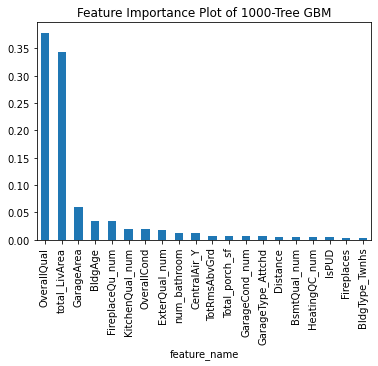

In [171]:
sorted_importance_gbm = sorted(zip(X_train.columns, gbm.feature_importances_), key=lambda t:t[1], reverse=True)
print(pd.DataFrame(sorted_importance_gbm[:20]))
a, b = zip(*sorted_importance_gbm[:20]) # this splits the list of tuples into two lists
pd.DataFrame({'feature_name':a, 'importance_score':b}).plot.bar(x='feature_name',y='importance_score', legend=None)
plt.title('Feature Importance Plot of 1000-Tree GBM')

In [174]:
[25, 50, 100]

[25, 50, 100]

In [173]:
grid_para_gbm = [{
    'criterion':['friedman_mse', 'mse', 'mae'],
    'learning_rate': np.linspace(0.01,0.1,10), 
    'n_estimators':range(1,100,10),
}]


grid_search_gbm = GridSearchCV(gbm, grid_para_gbm, cv=5, scoring='r2', n_jobs=-1)
%time grid_search_gbm.fit(X_train, y_train)

print(grid_search_gbm.best_params_)

print(grid_search_gbm.best_score_)

KeyboardInterrupt: 

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import r2_score
# housing_prediction = lin_reg.predict(X_test)
# mean_squared_error(y_train,y_test)
# lin_reg2 = LinearRegression().fit(X_train,y_train)
# lin_reg.r2_score